Device: cpu
Building the style transfer model...
Optimizing...
run 50:
Style Loss : 809.5575 Content Loss: 53.1072

run 100:
Style Loss : 203.0426 Content Loss: 58.2228

run 150:
Style Loss : 103.0592 Content Loss: 59.1427

run 200:
Style Loss : 62.6359 Content Loss: 59.4254

run 250:
Style Loss : 41.7589 Content Loss: 59.1080

run 300:
Style Loss : 31.3909 Content Loss: 58.5075

Building the style transfer model...
Optimizing...
run 50:
Style Loss : 946.9904 Content Loss: 70.8071

run 100:
Style Loss : 209.0730 Content Loss: 69.6211

run 150:
Style Loss : 100.2825 Content Loss: 69.1729

run 200:
Style Loss : 57.6148 Content Loss: 68.6822

run 250:
Style Loss : 37.9220 Content Loss: 67.6983

run 300:
Style Loss : 27.5630 Content Loss: 66.5093

Building the style transfer model...
Optimizing...
run 50:
Style Loss : 1328.4153 Content Loss: 67.5290

run 100:
Style Loss : 277.5489 Content Loss: 68.0107

run 150:
Style Loss : 121.8991 Content Loss: 68.0207

run 200:
Style Loss : 69.5281 Con

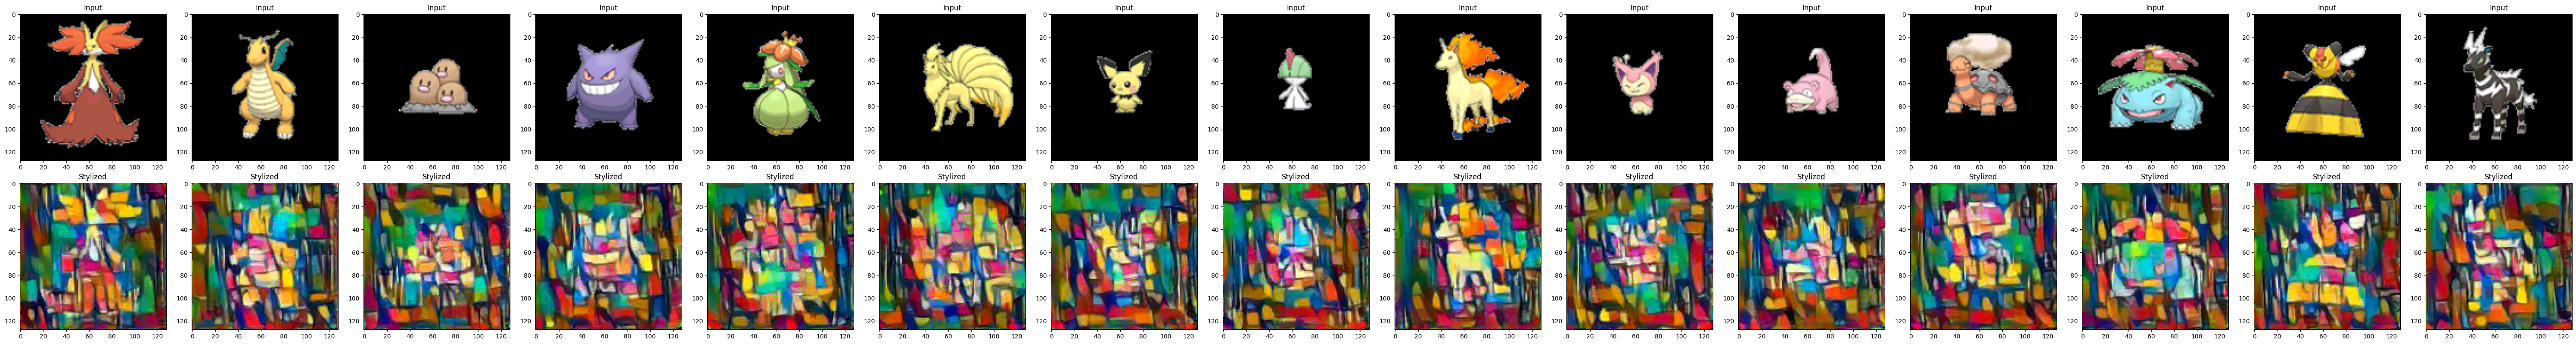

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import os
import copy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print("Device:", device)


imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name).convert("RGB")
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

unloader = transforms.ToPILImage()


plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)


class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    return optim.LBFGS([input_img])


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img,
                       num_steps=300, style_weight=1000000, content_weight=1):

    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img
    )

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f"Style Loss : {style_score.item():.4f} "
                      f"Content Loss: {content_score.item():.4f}\n")

            return loss

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


style_img = image_loader("style.jpg")#стиль абстракціонізм
Pokemon = "Pokemon"#візьмемо довільних 15 картинок з датасету https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types

inputs = []
outputs = []

for filename in sorted(os.listdir(Pokemon)):
    if not filename.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    content_img = image_loader(os.path.join(Pokemon, filename))
    input_img = content_img.clone()

    output = run_style_transfer(
        cnn,
        cnn_normalization_mean,
        cnn_normalization_std,
        content_img,
        style_img,
        input_img
    )

    inputs.append(content_img)
    outputs.append(output)


n = 15
plt.figure(figsize=(4 * n, 8))

for i in range(n):
    plt.subplot(2, n, i + 1)
    img = inputs[i].cpu().squeeze(0)
    plt.imshow(unloader(img))
    plt.title("Input")
    plt.subplot(2, n, i + 1 + n)
    img = outputs[i].cpu().squeeze(0)
    plt.imshow(unloader(img))
    plt.title("Stylized")

plt.tight_layout()
plt.show()
